### **Step 1: Import Libraries**

**Purpose:** Import necessary libraries for 
-image processing **(cv2)**, 
- file handling **(os, shutil)**, 
- plotting **(matplotlib)**, and to 
- suppress warnings **(warnings)**.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import shutil

import warnings
warnings.filterwarnings("ignore")

### **Step 2: Set Dataset Paths and Initialize Variables**

- **Purpose:** Define the paths for the image and label datasets and specify the subfolders **(train, val, test)** that the dataset is organized into.

In [2]:
dataset_base_path = "../Data/tiny_object_detection_yolo/images"  # Path to the dataset images
labels_base_path = "../Data/tiny_object_detection_yolo/labels"  # Path to the dataset labels

subfolders = ['train', 'val', 'test']  # Subfolders for train, validation, and test datasets

### **Step 3:** List Image Files

- **Purpose:** Create a list of all image files (with extensions **.jpg, .png, .jpeg**) in the subfolders **(train, val, test)**.

In [3]:
image_files = []  # Initialize a list to hold image file information
for folder in subfolders:  # Iterate over each subfolder (train, val, test)
    image_folder = os.path.join(dataset_base_path, folder)  # Get the full path to the image folder
    images_in_folder = [f for f in os.listdir(image_folder) 
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]  # List image files with specific extensions
    image_files.extend([(folder, f) for f in images_in_folder])  # Add image files to the list along with their folder name

### **Step 4: Read YOLO Annotations**

- **Purpose:** Define a function to read and parse YOLO annotation files, converting each line into a list of floating-point values.

In [4]:
def read_yolo_annotations(label_file):
    with open(label_file, "r") as f:  # Open the label file in read mode
        lines = f.readlines()  # Read all lines from the file
    return [list(map(float, line.strip().split())) for line in lines]  # Convert each line to a list of floats and return as a list

### **Step 5:** 📝 Load and Visualize the Dataset With Annotations

**🛠 What This Code Does**
- ✅ Loads all image paths from the dataset folder.
- ✅ Reads corresponding YOLO annotations from .txt files.
- ✅ Draws bounding boxes (red for "Building", green for other classes).
- ✅ Displays 5 sample images with their annotations.

- **Purpose:** Define a function to visualize images with bounding boxes drawn based on YOLO annotations. Class 0 (Building) annotations are highlighted in red, others in green.

In [5]:
def visualize_image(image_path, label_path):
    img = cv2.imread(image_path)  # Read the image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB for proper display in Matplotlib

    height, width, _ = img.shape  # Get the height and width of the image

    if os.path.exists(label_path):  # Check if the corresponding label file exists
        annotations = read_yolo_annotations(label_path)  # Read the YOLO annotations
        for ann in annotations:  # Iterate over each annotation
            class_id, x_center, y_center, w, h = ann  # Extract class id and bounding box info from the annotation
            x1 = int((x_center - w / 2) * width)  # Calculate the top-left x-coordinate of the bounding box
            y1 = int((y_center - h / 2) * height)  # Calculate the top-left y-coordinate of the bounding box
            x2 = int((x_center + w / 2) * width)  # Calculate the bottom-right x-coordinate of the bounding box
            y2 = int((y_center + h / 2) * height)  # Calculate the bottom-right y-coordinate of the bounding box

            # Draw the bounding box on the image, using different colors for different classes
            color = (255, 0, 0) if int(class_id) == 0 else (0, 255, 0)  # Red for "Building", Green for others
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)  # Draw the rectangle on the image

    # Step 7: Display the image with the bounding boxes
    plt.figure(figsize=(6, 6))  # Set the figure size for the plot
    plt.imshow(img)  # Display the image
    plt.axis("off")  # Hide the axes for better visualization
    plt.show()  # Show the image with the bounding boxes

### **Step 6:** Display Sample Images and Annotations

- **Purpose:** Display 15 sample images (5 from each folder) along with their YOLO annotations to verify the dataset content.

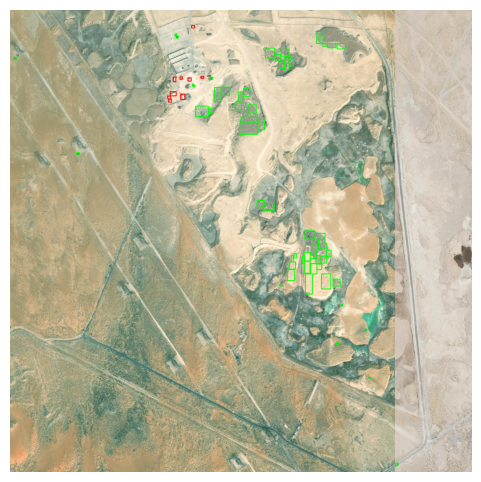

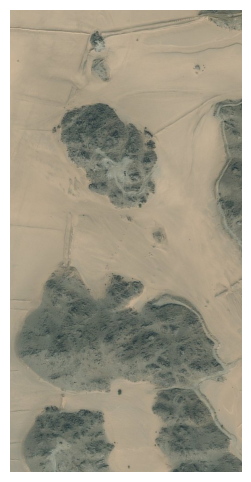

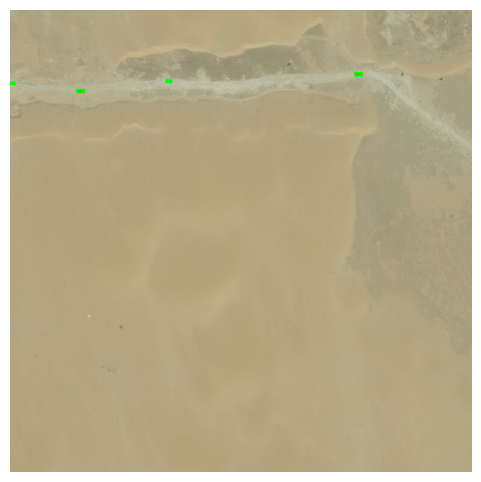

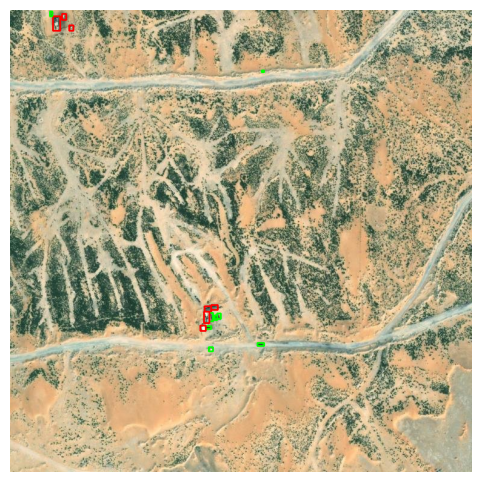

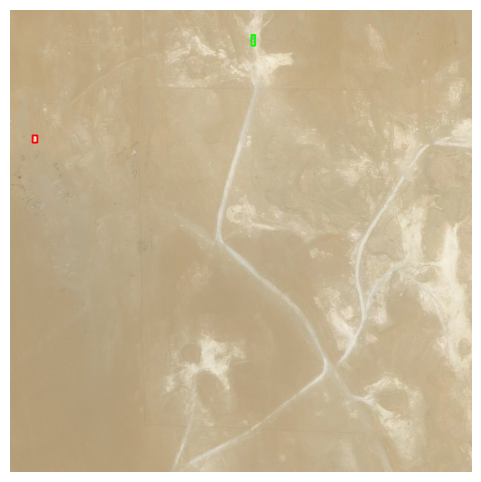

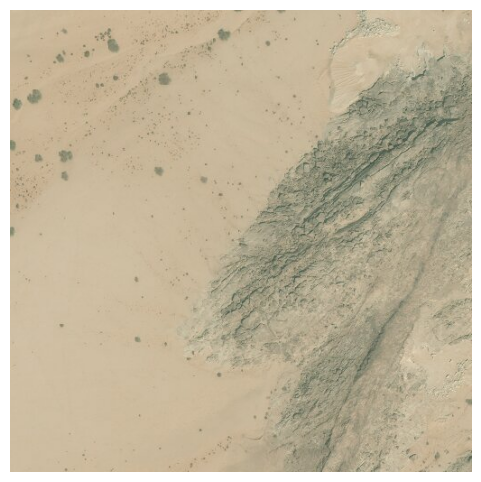

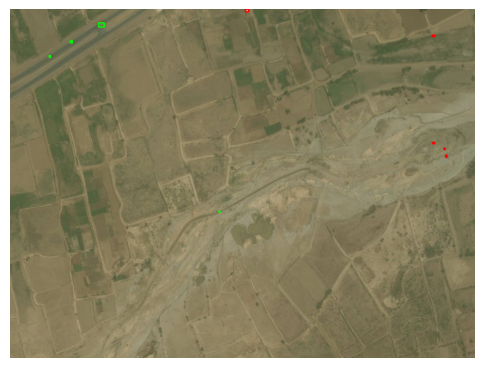

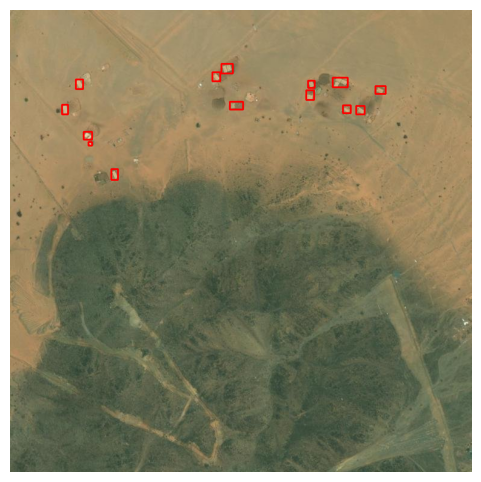

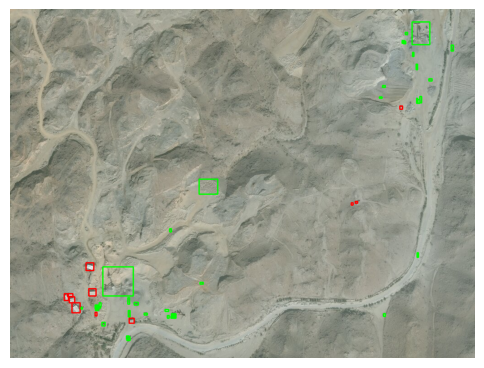

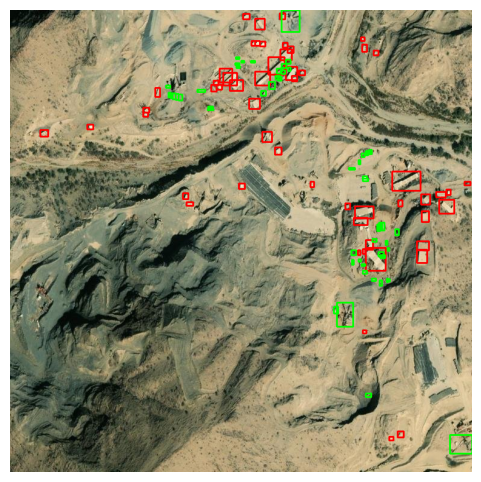

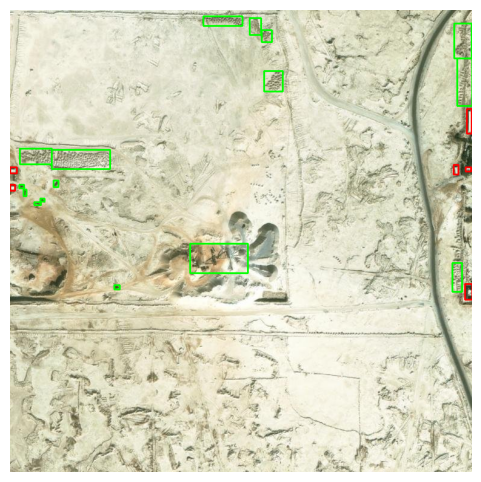

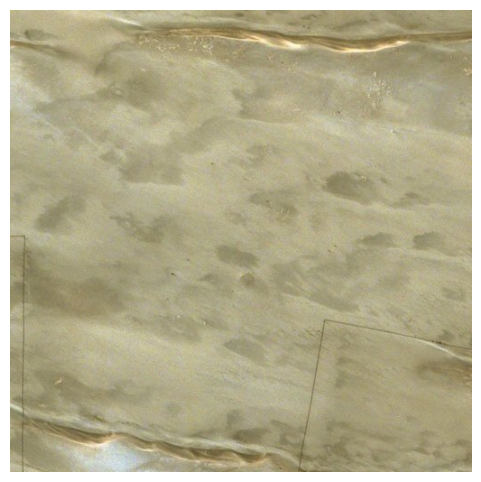

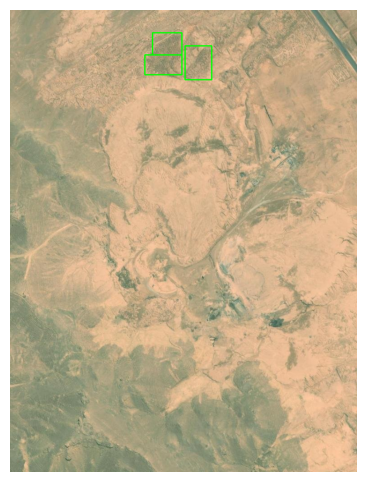

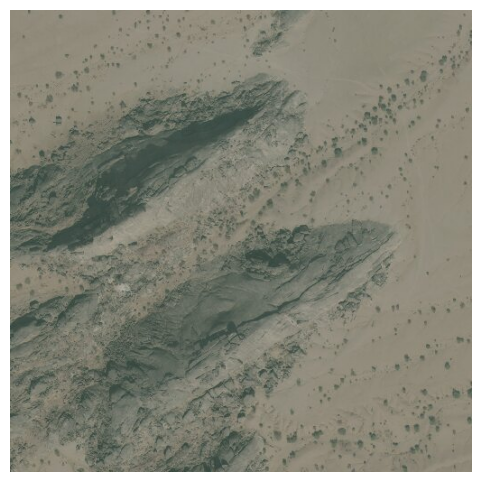

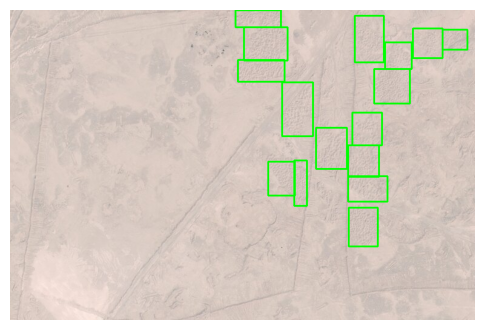

In [6]:
for folder, image_name in image_files[:15]:  # Display 15 images (5 from each folder)
    image_path = os.path.join(dataset_base_path, folder, image_name)  # Get the full path to the image
    label_path = os.path.join(labels_base_path, folder, image_name.replace(".jpg", ".txt").replace(".png", ".txt"))  # Get the corresponding label file path
    visualize_image(image_path, label_path)  # Call the function to visualize the image with annotations

## **My Assumptions 🤔:**
**🔍 Problem with Skipping Labels**
- If an image has no "Building" class annotations, its label file is skipped.
- However, the corresponding image remains in the dataset, which can cause issues during training.
- The model might expect a label file for every image, leading to errors or inconsistencies.

**✅ Solution: Remove Unlabeled Images**
- If an annotation file is skipped, delete the corresponding image from the dataset.
- This ensures that the model only trains on images that contain "Building" labels.

**🚀 Why This is Better?**

**✔ Ensures Data Consistency**

- Removes images that have no "Building" labels, preventing them from being used in training.

**✔ Creates a New Filtered Dataset**

- Instead of modifying the original dataset, it saves the filtered labels & images in separate folders (filtered_labels, filtered_images).

**✔ Avoids Training Issues**

Prevents model errors due to missing label files.


### **🔍 Should We Remove Images from Validation & Test Sets❓**
- Yes, we should remove images from validation and test sets as well if they do not contain the "Building" class.

#### **🤷‍♂️ Why Remove from Validation & Test Sets❓**

✅ **1. Ensures Model Evaluation is Relevant**
- Validation and test sets should only contain images with "Building" objects because we are training the model only on "Building" labels.
Keeping irrelevant images in validation/test can cause misleading evaluation results.

✅ **2. Prevents Errors in mAP Calculation**
- Object detection models evaluate performance using mAP (Mean Average Precision), which compares predicted vs. ground truth annotations.
If an image has no ground truth labels, it could skew the performance metrics (e.g., false positives from predicted bounding boxes).

✅ **3. Keeps Label-Image Consistency**
- Removing images ensures that every label file has a corresponding image and vice versa.

### **✅ Step 7:** Filter Out Only the 'Building' Class (Class 0)

**📌 What We Need to Do**
- Read each YOLO annotation file in the labels/train, labels/val, and labels/test folders.
- Remove all lines where the class ID is not 0 (Building).
- Save the filtered annotation files back.


**📌 Implementation Plan**
- Loop through all annotation files.
- Keep only class 0 entries in each .txt file.
- Save the cleaned files in the same location.

- **Purpose:** Define a function to filter annotations and images to keep only those containing "Building" annotations (class 0). The filtered labels and images are saved into new folders.

In [7]:
def filter_building_annotations(labels_base_path, images_base_path, output_labels_path, output_images_path, subfolders):
    # Step 1: Clear old outputs to avoid duplicates
    if os.path.exists(output_labels_path):
        shutil.rmtree(output_labels_path)  # Remove old label files
    if os.path.exists(output_images_path):
        shutil.rmtree(output_images_path)  # Remove old images

    # Step 2: Create fresh output directories
    os.makedirs(output_labels_path, exist_ok=True)
    os.makedirs(output_images_path, exist_ok=True)

    kept_count, skipped_count = 0, 0  # Track saved vs skipped images

    # Step 3: Process each dataset split (train, val, test)
    for folder in subfolders:
        input_label_folder = os.path.join(labels_base_path, folder)
        input_image_folder = os.path.join(images_base_path, folder)

        output_label_folder = os.path.join(output_labels_path, folder)
        output_image_folder = os.path.join(output_images_path, folder)

        os.makedirs(output_label_folder, exist_ok=True)
        os.makedirs(output_image_folder, exist_ok=True)

        # Step 4: Process each label file
        for label_file in os.listdir(input_label_folder):
            if not label_file.endswith(".txt"):
                continue  # Skip non-label files
            
            input_label_path = os.path.join(input_label_folder, label_file)
            output_label_path = os.path.join(output_label_folder, label_file)

            # Step 5: Find corresponding image (handle multiple formats)
            image_filename = None
            image_extensions = [".jpg", ".png", ".jpeg"]
            for ext in image_extensions:
                temp_path = os.path.join(input_image_folder, label_file.replace(".txt", ext))
                if os.path.exists(temp_path):
                    image_filename = temp_path
                    break  # Stop once we find the correct image file
            
            if image_filename is None:
                print(f"⚠️ No image found for {label_file}, skipping.")
                continue  # Skip labels without a matching image

            # Step 6: Read annotations and filter class "0" (Building)
            with open(input_label_path, "r") as f:
                lines = f.readlines()

            filtered_lines = [line for line in lines if line.split()[0] == "0"]  # Keep only building annotations

            if filtered_lines:
                # Step 7: Save the filtered annotations
                with open(output_label_path, "w") as f:
                    f.writelines(filtered_lines)

                # Step 8: Copy the image to correct folder
                output_image_path = os.path.join(output_image_folder, os.path.basename(image_filename))
                shutil.copy(image_filename, output_image_path)

                print(f"✅ Kept: {os.path.basename(image_filename)} - {len(filtered_lines)} Buildings")
                kept_count += 1
            else:
                print(f"❌ Skipped: {label_file} - No buildings")
                skipped_count += 1

    # Step 9: Print summary
    print(f"\nSummary:")
    print(f"✅ Total images kept: {kept_count}")
    print(f"❌ Total images skipped: {skipped_count}")

### **Step 8:** Run Filtering for Building Class

- **Purpose:** Run the filtering function to keep only the images and labels containing "Building" annotations. The filtered data is saved to new directories.

In [8]:
filtered_labels_path = "../Data/tiny_object_detection_yolo/filtered_labels"  # Path to store filtered labels
filtered_images_path = "../Data/tiny_object_detection_yolo/filtered_images"  # Path to store filtered images

filter_building_annotations(labels_base_path, dataset_base_path, filtered_labels_path, filtered_images_path, subfolders)

# Step 9: Output Completion Message
print("✅ Filtering complete. Filtered images & labels are saved in:", filtered_labels_path, filtered_images_path)

✅ Kept: 1_Renew_Licenced_Small_1_2022.png - 9 Buildings
❌ Skipped: 1005_licenced_Building_1_2016.txt - No buildings
❌ Skipped: 1010_Expired_Notified_Building_1_2014.txt - No buildings
✅ Kept: 1010_Expired_Notified_Building_1_2023.png - 7 Buildings
✅ Kept: 1011_Expired_Notified_Building_1_2016.png - 1 Buildings
❌ Skipped: 1016_licenced_Building_1_2015.txt - No buildings
✅ Kept: 1032_Expired_Notified_Building_1_2018.png - 5 Buildings
✅ Kept: 1033_Expired_Notified_Building_1_2020.png - 14 Buildings
✅ Kept: 1039_Expired_Notified_Building_1_2014.png - 11 Buildings
✅ Kept: 106_Renew_Licenced_Building_1_2021.png - 55 Buildings
✅ Kept: 1060_Expired_Notified_Building_1_2022.png - 6 Buildings
❌ Skipped: 1064_licenced_Building_1_2018.txt - No buildings
❌ Skipped: 1065_licenced_Building_1_2021.txt - No buildings
❌ Skipped: 1067_Expired_Notified_Building_1_2015.txt - No buildings
❌ Skipped: 107_Renew_Licenced_Building_1_2016.txt - No buildings
✅ Kept: 1072_licenced_Building_1_2020.png - 2 Buildings